In [2]:
import itertools
import matplotlib
import matplotlib.style
import numpy as np
import pandas as pd
import sys
from tqdm import tqdm
from pprint import pprint
from collections import defaultdict
import plotting
import math
import pickle
from train_util import createEpsilonGreedyPolicy
matplotlib.style.use('ggplot')

In [3]:
"""
turn = 1 # 先手
turn = 2 # 後手
action = 0 ~ 8
"""
class Board:
    def __init__(self):
        self.board = [[0 for i in range(3)] for i in range(3)]
        
    def reset(self):
        self.board = [[0 for i in range(3)] for i in range(3)]
    
    def get_turn(self):
        cnt_first = 0
        cnt_second = 0
        for i in range(3):
            for j in range(3):
                if self.board[i][j] == 1:
                    cnt_first += 1 
                elif self.board[i][j] == 2:
                    cnt_second += 1
        if cnt_first == cnt_second:
            return 1
        else:
            return 2
    
    def executable(self, action):
        i, j = action // 3, action % 3
        return self.board[i][j] == 0
        
    def execute(self, action, turn):
        i, j = action // 3, action % 3
        self.board[i][j] += turn
        return
    
    """
    0: ゲーム途中
    1: 先手勝ち
    2: 後手勝ち
    3: 引き分け
    """
    def judge(self):
        # 縦
        for i in range(3):
            if self.board[i][0] == self.board[i][1] == self.board[i][2] != 0:
                return self.board[i][0]
        # 横
        for j in range(3):
            if self.board[0][j] == self.board[1][j] == self.board[2][j] != 0:
                return self.board[0][j]
        # 斜め
        if self.board[0][0] == self.board[1][1] == self.board[2][2] != 0:
            return self.board[0][0]
        if self.board[0][2] == self.board[1][1] == self.board[2][0] != 0:
            return self.board[0][2]

        # 全部埋まっているか
        for i in range(3):
            for j in range(3):
                if self.board[i][j] == 0:
                    return 0
        return 3

In [4]:
class TicTacToeEnv:
    def __init__(self, opponent):
        self.action_cnt = 9
        self.state_cnt = 3 ** 9
        self.state = 0
        self.board = Board()
        self.opponent = opponent
    
    def updateState(self):
        state = 0
        bi = 1
        for i in range(3):
            for j in range(3):
                state += bi * self.board.board[i][j]
                bi *= 3
        self.state = state
        
    def get_turn(self):
        return self.board.get_turn()
    
    def execute(self, action, turn):
        self.board.execute(action, turn)
        self.updateState()
        return
    
    def executable(self, action):
        return self.board.executable(action)
    
    def judge(self):
        return self.board.judge()
    
    def reset(self):
        self.board.reset()
        self.updateState()
        return self.state
            
    def getExecutableAction(self):
        executableList = []
        for i in range(self.action_cnt):
            if self.executable(i):
                executableList.append(i)
        return executableList
    
    def step(self, action):
        # check if action is valid
        assert self.executable(action)
        
        turn = self.get_turn()
        self.execute(action, turn)
        winner = self.judge()
        if winner == turn:
            reward = 1
            done = 1            
        elif winner == 3:
            reward = 0
            done = 1            
        else:
            action = self.opponent.getAction(self.state, self.getExecutableAction())
            turn = self.get_turn()
            self.execute(action, turn)
            winner = self.judge()
            if winner == turn:
                reward = -1
                done = 1  
            elif winner == 3:
                reward = 0
                done = 1
            else:
                reward = 0
                done = 0
        return self.state, reward, done

In [5]:
def qLearning(env, num_episodes, discount_factor = 1.0, alpha = 0.6, epsilon = 0.1):    
    
    Q = [np.zeros(env.action_cnt) for i in range(env.state_cnt)]
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths = np.zeros(num_episodes),
        episode_rewards = np.zeros(num_episodes))    
       
    policy = createEpsilonGreedyPolicy(Q, epsilon, env.action_cnt)
    
    for ith_episode in tqdm(range(num_episodes)):
        # Reset the environment and pick the first action
        state = env.reset()
        experience = []
        for t in itertools.count():
            action_probabilities = policy(state)
            executableActionList = env.getExecutableAction()
            while True:
                action = np.random.choice(np.arange(len(action_probabilities)), p = action_probabilities)
                if action in executableActionList:
                    break
            
#             if t == 0:
#                 print("first action: ", action)
            next_state, reward, done = env.step(action)
            td_delta = reward + discount_factor * Q[next_state].max() - Q[state][action]
            Q[state][action] += alpha * td_delta
#             if t == 0:
#                 print("update state action")
#                 print(state, action, alpha * td_delta)
            state = next_state
            if done:
                break
        stats.episode_rewards[ith_episode] = reward
    return Q, stats

In [6]:
class RandomAgent:
    def getAction(self, state, executableActionList):
        return np.random.choice(executableActionList)
    
oppenent = RandomAgent()

In [7]:
env = TicTacToeEnv(oppenent)

In [9]:
Q, stats = qLearning(env, 100)

100%|██████████| 100/100 [00:00<00:00, 345.58it/s]


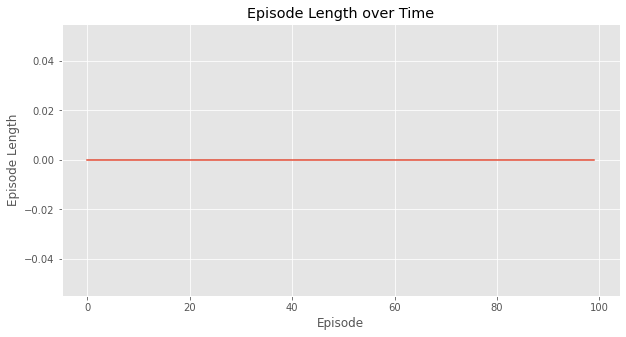

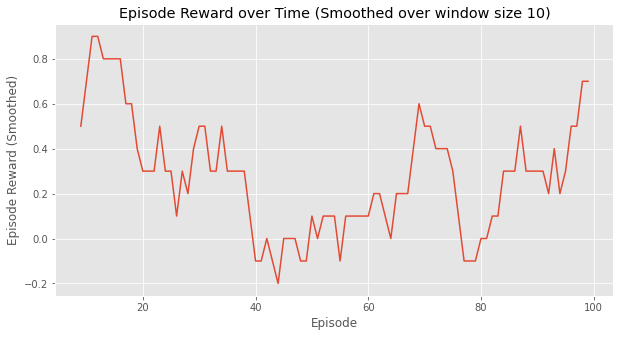

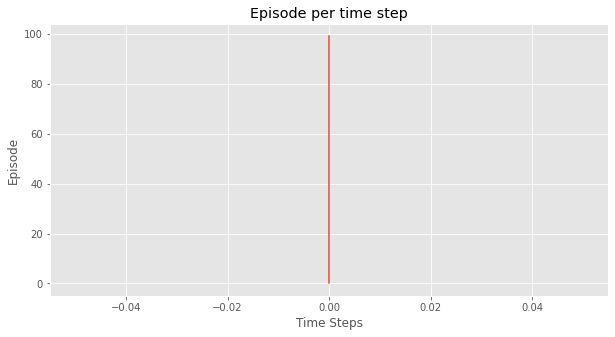

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [10]:
plotting.plot_episode_stats(stats)